In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


In [2]:
import json

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

#load the data
training_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json')
evaluation_solutions = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json')
training_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json')
evaluation_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json')
test_challenges = load_json('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json')
sample_submission = load_json('/kaggle/input/arc-prize-2024/sample_submission.json')

In [3]:
def inspect_data(data, num_samples=1):
    for key, value in list(data.items())[:num_samples]:
        print(f"Key: {key}")
        print(f"Sample Data: {value}\n")
        
print("Training Solutions:")
inspect_data(training_solutions)

print("Training Challenges:")
inspect_data(training_challenges)

print("Evaluation Solutions:")
inspect_data(evaluation_solutions)

print("Evaluation Challenges:")
inspect_data(evaluation_challenges)

print("Test Challenges:")
inspect_data(test_challenges)

print("Sample submission:")
inspect_data(sample_submission)

Training Solutions:
Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]

Training Challenges:
Key: 007bbfb7
Sample Data: {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0,

In [4]:
sample_key = list(training_solutions.keys())[0]
print(f"Sample Key: {sample_key}")
print("Sample Data:", training_solutions[sample_key])

Sample Key: 007bbfb7
Sample Data: [[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 7, 0, 0, 0, 0, 7, 7, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 0, 7, 7, 0, 7, 0, 0, 0], [7, 7, 0, 7, 7, 0, 0, 0, 0]]]


In [5]:
#compute the mean, standard deviation, minimum, and maximum values of the data
sample_data = training_solutions[sample_key]

#convert to numpy array
data_array = np.array(sample_data)

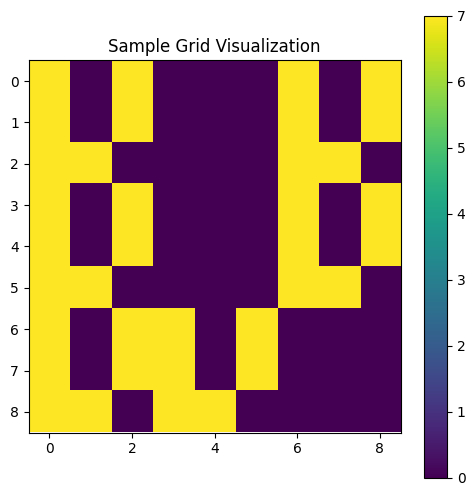

Grid Summary:
Mean Value: 3.11
Standard Deviation: 3.48
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences


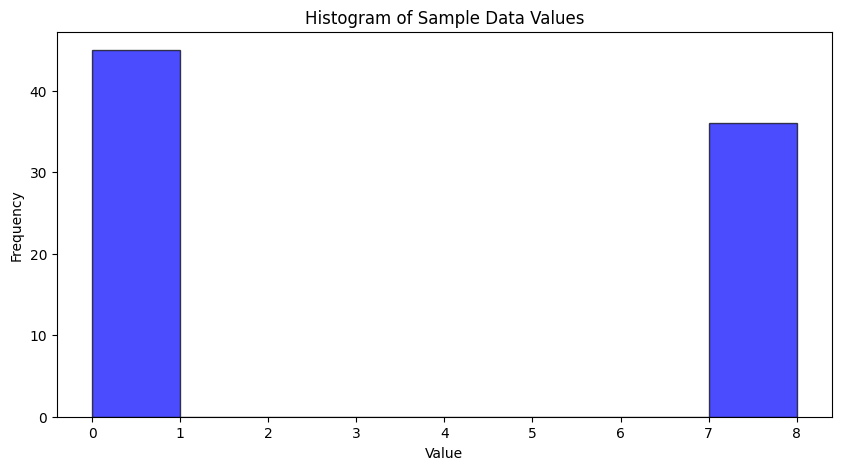

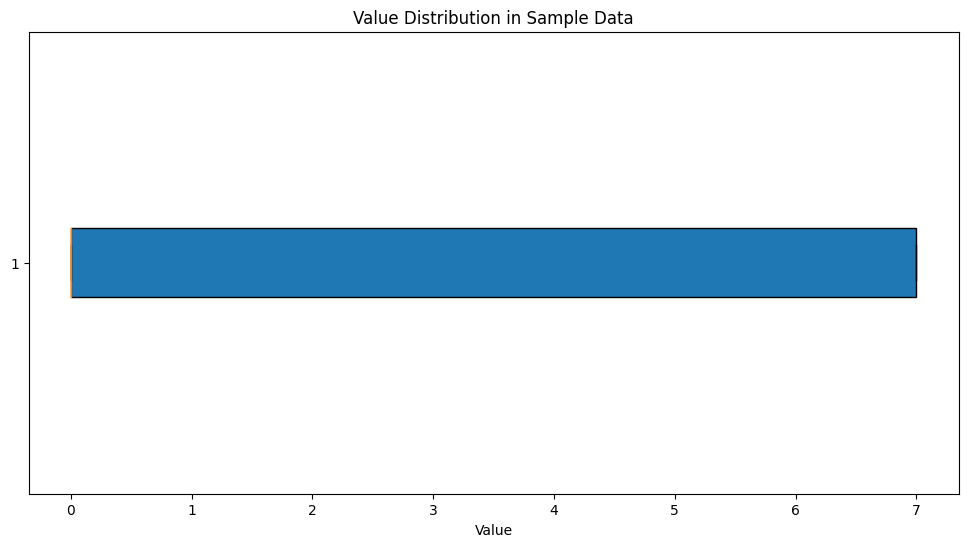

Histogram Summary:
Mean Value: 3.11
Median Value: 0.00
Minimum Value: 0
Maximum Value: 7

Frequency Distribution:
Value 0: 45 occurrences
Value 7: 36 occurrences
Boxplot Summary:
Median Value: 0.00
1st Quartile (Q1): 0.00
3rd Quartile (Q3): 7.00
Interquartile Range (IQR): 7.00
Minimum Value: 0
Maximum Value: 7
Number of Outliers: 0


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_grid(data, title="Grid Visualization"):
    #remove any singleton dimensions
    data_squeezed = np.squeeze(data)
    plt.figure(figsize=(6, 6))
    plt.imshow(data_squeezed, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def summarize_grid(data):
    #calculate basic statistics
    mean = np.mean(data)
    std_dev = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    
    #frequency distribution
    flat_data = data.flatten()
    freq_dist = Counter(flat_data)
    
    return mean, std_dev, min_val, max_val, freq_dist

def print_summary(mean, std_dev, min_val, max_val, freq_dist):
    print("Grid Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Standard Deviation: {std_dev:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def plot_histogram(data, title="Histogram of Data Values"):
    plt.figure(figsize=(10, 5))
    plt.hist(data.flatten(), bins=range(int(np.min(data)), int(np.max(data)) + 2), color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_value_distribution(data, title="Value Distribution"):
    plt.figure(figsize=(12, 6))
    plt.boxplot(data.flatten(), vert=False, patch_artist=True)
    plt.title(title)
    plt.xlabel('Value')
    plt.show()

def summarize_histogram(data):
    flat_data = data.flatten()
    mean = np.mean(flat_data)
    median = np.median(flat_data)
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    unique, counts = np.unique(flat_data, return_counts=True)
    freq_dist = dict(zip(unique, counts))
    
    print("Histogram Summary:")
    print(f"Mean Value: {mean:.2f}")
    print(f"Median Value: {median:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print("\nFrequency Distribution:")
    for value, count in sorted(freq_dist.items()):
        print(f"Value {value}: {count} occurrences")

def summarize_boxplot(data):
    flat_data = data.flatten()
    median = np.median(flat_data)
    q1 = np.percentile(flat_data, 25)
    q3 = np.percentile(flat_data, 75)
    iqr = q3 - q1
    min_val = np.min(flat_data)
    max_val = np.max(flat_data)
    outliers = flat_data[(flat_data < (q1 - 1.5 * iqr)) | (flat_data > (q3 + 1.5 * iqr))]

    print("Boxplot Summary:")
    print(f"Median Value: {median:.2f}")
    print(f"1st Quartile (Q1): {q1:.2f}")
    print(f"3rd Quartile (Q3): {q3:.2f}")
    print(f"Interquartile Range (IQR): {iqr:.2f}")
    print(f"Minimum Value: {min_val}")
    print(f"Maximum Value: {max_val}")
    print(f"Number of Outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Outlier Values:", np.unique(outliers))

#plot the grid
plot_grid(data_array, title="Sample Grid Visualization")

#get statistics and frequency distribution
mean, std_dev, min_val, max_val, freq_dist = summarize_grid(data_array)

#print textual summary
print_summary(mean, std_dev, min_val, max_val, freq_dist)

#plot histogram and boxplot
plot_histogram(data_array, title="Histogram of Sample Data Values")
plot_value_distribution(data_array, title="Value Distribution in Sample Data")

#print textual summaries for histogram and boxplot
summarize_histogram(data_array)
summarize_boxplot(data_array)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

#define the Yambi ("Welcome" in Kikongo) Class
class Yambi:
    """
    Yambi combines explainable autoencoder, evolutionary algorithms, 
    ethical AI practices, adaptive memory, and real-time learning.
    """

    def __init__(self):
        """
        Initialize the Yambi class with no autoencoder model.
        """
        self.autoencoder = None

    def initialize_autoencoder(self, num_units):
        """
        Initialize an autoencoder model with the given number of units in the encoding layer.
        
        Parameters:
        - num_units: int, number of units in the encoding layer.

        Returns:
        - autoencoder: Keras Model, compiled autoencoder model.
        """
        input_shape = (30, 30, 1)
        input_img = Input(shape=input_shape)
        
        #Encoder
        x = Flatten()(input_img)
        x = Dense(num_units, activation='relu')(x)
        x = Dropout(0.5)(x)  #Dropout for regularization
        
        #Decoder
        x = Dense(np.prod(input_shape), activation='sigmoid')(x)
        decoded = Reshape(input_shape)(x)
        
        #Autoencoder Model
        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
        
        return autoencoder

    def train_autoencoder(self, x_train, x_val, num_units):
        """
        Train the autoencoder model with the specified number of units.
        
        Parameters:
        - x_train: numpy array, training data.
        - x_val: numpy array, validation data.
        - num_units: int, number of units in the encoding layer.
        """
        if self.autoencoder is None:
            self.autoencoder = self.initialize_autoencoder(num_units)
        
        x_train = x_train.reshape((len(x_train), 30, 30, 1))
        x_val = x_val.reshape((len(x_val), 30, 30, 1))

        #define early stopping and model checkpoint
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

        #train the autoencoder
        self.autoencoder.fit(x_train, x_train,
                             epochs=50,
                             batch_size=128,
                             shuffle=True,
                             validation_data=(x_val, x_val),
                             callbacks=[early_stopping, model_checkpoint])
    
    def evaluate_autoencoder(self, x_val):
        """
        Evaluate the autoencoder model on validation data and compute the mean squared error.
        
        Parameters:
        - x_val: numpy array, validation data.

        Returns:
        - mse: float, mean squared error of the model's predictions on the validation data.
        """
        x_val = x_val.reshape((len(x_val), 30, 30, 1))
        reconstructed = self.autoencoder.predict(x_val)
        mse = mean_squared_error(x_val.flatten(), reconstructed.flatten())
        return mse

    def explain_prediction(self, input_grid):
        """
        Generate a basic explanation for the model's predictions.
        
        Parameters:
        - input_grid: numpy array, input grid for which to generate an explanation.

        Returns:
        - explanation: numpy array, simplified explanation of the input grid.
        """
        explanation = np.mean(input_grid, axis=-1)
        return explanation

    def apply_ethics(self, solution):
        """
        Apply ethical checks to the generated solution.
        
        Parameters:
        - solution: numpy array, the solution to check.

        Returns:
        - solution: numpy array, the checked and potentially modified solution.
        """
        solution = self.apply_fairness_check(solution)
        solution = self.apply_transparency_check(solution)
        solution = self.apply_safety_check(solution)
        solution = self.apply_privacy_check(solution)
        return solution

    def apply_fairness_check(self, solution):
        """
        Ensure that the solution is not completely devoid of information, addressing fairness concerns.
        
        Parameters:
        - solution: numpy array, the solution to check.

        Returns:
        - solution: numpy array, the modified solution ensuring some information is present.
        """
        if np.all(solution == 0):
            solution[0, 0] = 1  #avoid completely black grid to prevent bias
        return solution

    def apply_transparency_check(self, solution):
        """
        Ensure that the solution contains some non-zero values to maintain transparency.
        
        Parameters:
        - solution: numpy array, the solution to check.

        Returns:
        - solution: numpy array, the modified solution ensuring some information is present.
        """
        if np.count_nonzero(solution) == 0:
            solution[0, 0] = 1  #ensure some information is present
        return solution

    def apply_safety_check(self, solution):
        """
        Ensure that the solution does not contain values outside the valid range, maintaining safety.
        
        Parameters:
        - solution: numpy array, the solution to check.

        Returns:
        - solution: numpy array, the modified solution with values clipped to the valid range.
        """
        solution = np.clip(solution, 0, 9)  #clip values to be within the valid range
        return solution

    def apply_privacy_check(self, solution):
        """
        Ensure that the solution does not expose sensitive data, maintaining privacy.
        
        Parameters:
        - solution: numpy array, the solution to check.

        Returns:
        - solution: numpy array, the modified solution with values clipped to the valid range.
        """
        solution = np.clip(solution, 0, 9)  #ensure values are within valid range
        return solution
    
    def predict(self, input_grid):
        """
        Predict the output for a given input grid, applying evolutionary algorithms and ethical checks.
        Ensure predictions are clipped to the range [0, 9] and are integers.
        """
        input_grid = input_grid.reshape(1, 30, 30, 1)
        if self.autoencoder is not None:
            encoded_grid = self.autoencoder.predict(input_grid)
            evolved_solution = self.evolve_solutions(encoded_grid[0])
            ethical_solution = self.apply_ethics(evolved_solution)
            
            #ensure the predictions are clipped to the range [0, 9] and are integers
            clipped_solution = np.clip(ethical_solution, 0, 9)
            final_solution = clipped_solution.astype(int)
            
            return final_solution
        else:
            raise ValueError("Autoencoder model is not initialized.")

    def evaluate_explanations(self, x_val):
        """
        Evaluate explanations for a set of validation inputs.
        
        Parameters:
        - x_val: numpy array, validation inputs.

        Returns:
        - explanations: list of numpy arrays, explanations for each validation input.
        """
        explanations = [self.explain_prediction(x) for x in x_val]
        return explanations

    def evolve_solutions(self, input_grid):
        """
        Apply a simple evolutionary step to the input grid (e.g., rotation).
        
        Parameters:
        - input_grid: numpy array, the input grid to evolve.

        Returns:
        - evolved_solution: numpy array, the evolved solution.
        """
        return np.rot90(input_grid)

    def optimize_autoencoder(self, x_train, x_val, num_generations=10, population_size=10):
        """
        Optimize the number of units in the autoencoder using an evolutionary algorithm.
        
        Parameters:
        - x_train: numpy array, training data.
        - x_val: numpy array, validation data.
        - num_generations: int, number of generations for optimization.
        - population_size: int, size of the population in each generation.

        Returns:
        - best_num_units: int, the optimal number of units found.
        """
        best_num_units = 32  #initial best number of units
        best_mse = float('inf')
        
        for gen in range(num_generations):
            population = [np.random.randint(32, 256) for _ in range(population_size)]
            for num_units in population:
                self.train_autoencoder(x_train, x_val, num_units)
                mse = self.evaluate_autoencoder(x_val)
                
                if mse < best_mse:
                    best_mse = mse
                    best_num_units = num_units
                    
            print(f"Generation {gen+1}: Best MSE = {best_mse} with {best_num_units} units")

        return best_num_units

def pad_array(array, target_size, pad_value=0):
    """
    Pad an array to the target size with the specified padding value.
    
    Parameters:
    - array: numpy array, the array to pad.
    - target_size: int, the target size of the padded array.
    - pad_value: int, value to pad with.

    Returns:
    - padded: numpy array, the padded array.
    """
    padded = np.full((target_size, target_size), pad_value, dtype=int)
    original_size = array.shape
    padded[:original_size[0], :original_size[1]] = array
    return padded

def preprocess_data(challenges, solutions, max_size=30):
    """
    Preprocess data by padding grids and organizing them into training and validation sets.
    
    Parameters:
    - challenges: dict, the challenge data.
    - solutions: dict, the solution data.
    - max_size: int, the size to pad arrays to.

    Returns:
    - x_data: numpy array, preprocessed input data.
    - y_data: numpy array, preprocessed output data.
    """
    x_data = []
    y_data = []

    for challenge_key in challenges:
        challenge = challenges[challenge_key]
        solution = solutions[challenge_key]

        for train_example in challenge['train']:
            x_grid = np.array(train_example['input'])
            y_grid = np.array(train_example['output'])
            
            #pad arrays to the target size
            x_grid_padded = pad_array(x_grid, max_size)
            y_grid_padded = pad_array(y_grid, max_size)
            
            x_data.append(x_grid_padded)
            y_data.append(y_grid_padded)

    return np.array(x_data), np.array(y_data)

def prepare_submission(test_challenges, model, output_path):
    """
    Prepare and save predictions for the test challenges in a submission file.
    
    Parameters:
    - test_challenges: dict, the test challenge data.
    - model: Yambi, trained Yambi model.
    - output_path: str, path to save the submission file.
    """
    results = {}
    
    for challenge_key, challenge_data in test_challenges.items():
        challenge_results = []

        #check if 'test' key exists and is a list
        if 'test' in challenge_data and isinstance(challenge_data['test'], list):
            for attempt_idx in range(2):  #two attempts per key
                if len(challenge_data['test']) > 0 and isinstance(challenge_data['test'][0], dict) and 'input' in challenge_data['test'][0]:
                    #use the same input for both attempts
                    input_grid = np.array(challenge_data['test'][0]['input'])
                    input_grid = pad_array(input_grid, 30)
                    prediction = model.predict(input_grid)
                    
                    #convert prediction to a list, clip values to integers between 0 and 9
                    prediction_list = prediction.tolist()
                    attempt_result = {f"attempt_{attempt_idx + 1}": prediction_list}
                    challenge_results.append(attempt_result)
                else:
                    print(f"Unexpected data format in test data for key '{challenge_key}': {challenge_data['test']}")
        else:
            print(f"Unexpected data format for key '{challenge_key}': {challenge_data}")

        results[challenge_key] = challenge_results
        
    #save results to submission.json
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=4)

#preprocess data
x_train, y_train = preprocess_data(training_challenges, training_solutions)
x_val, y_val = preprocess_data(evaluation_challenges, evaluation_solutions)

#instantiate and train the Yambi model with the optimized parameters
yambi_model = Yambi()
best_num_filters = yambi_model.optimize_autoencoder(x_train, x_val)
print(f"Best number of filters found: {best_num_filters}")

#train the final model with the best number of filters
yambi_model.train_autoencoder(x_train, x_val, best_num_filters)

#evaluate on validation data
mse = yambi_model.evaluate_autoencoder(x_val)
print(f"Mean Squared Error on Validation Data: {mse}")

#generate explanations and make predictions
explanations = yambi_model.evaluate_explanations(x_val)
print(f"Generated Explanations: {explanations}")

#define output path for submission
output_path = '/kaggle/working/submission.json'

#generate and save the predictions
prepare_submission(test_challenges, yambi_model, output_path)

2024-08-24 06:56:28.323860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 06:56:28.324003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 06:56:28.487859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.6386 - val_loss: -0.1885
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1091 - val_loss: -1.7069
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.8008 - val_loss: -2.6934
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.1440 - val_loss: -3.1980
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.5225 - val_loss: -3.4396
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.4803 - val_loss: -3.5468
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.5599 - val_loss: -3.6337
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.7086 - val_loss: -3.6874
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.6794 - val_loss: -3.7240
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -1.6122 - val_loss: -3.7622
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -1.8157 - val_loss: -3.7949
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 